<a href="https://colab.research.google.com/github/leunseo/leunseo/blob/main/Final_Project23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# importing Stopwords
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
import re

# Processing
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences


# models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Sequential
from keras.layers import  Input
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN

# train test split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Pipeline
from sklearn.pipeline import Pipeline

# score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [200]:
#import data
mail = pd.read_csv("/content/df.csv", encoding="latin-1", usecols=["v1", "v2"])
mail = mail.copy()
mail.columns = ["label", "text"]
mail = mail[["text", "label"]]
mail["label"] = mail["label"].map({"ham": 0, "spam": 1}) #spam:1, ham:0
mail.head()

,text,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0


In [201]:
#Checking for misssing values
mail.isnull().sum()

text     0
label    0
dtype: int64

In [202]:
#Finding duplicate and Removing duplicate
mail.duplicated().sum() #403
mail = mail.drop_duplicates(keep='first')

#Result after removing duplicate
mail.duplicated().sum() #0

0

In [203]:
mail['label'].value_counts() #Number of spam: 653, Number of ham:4516

0    4516
1     653
Name: label, dtype: int64

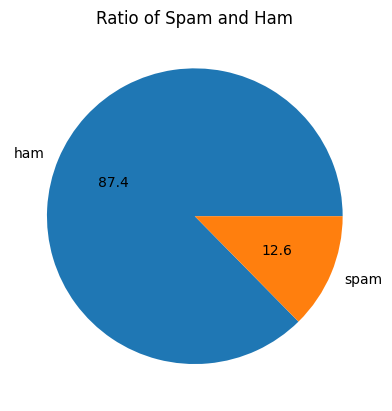

In [204]:
#Check data imbalances
from matplotlib import pyplot as plt

plt.pie(mail['label'].value_counts(), labels=['ham','spam'],autopct="%0.1f")
plt.title('Ratio of Spam and Ham')
plt.show()

In [205]:
mail['length'] = mail['text'].apply(len)
mail.head()

,text,label,length
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives around here though",0,61


Text(0.5, 1.0, 'Length of Text')

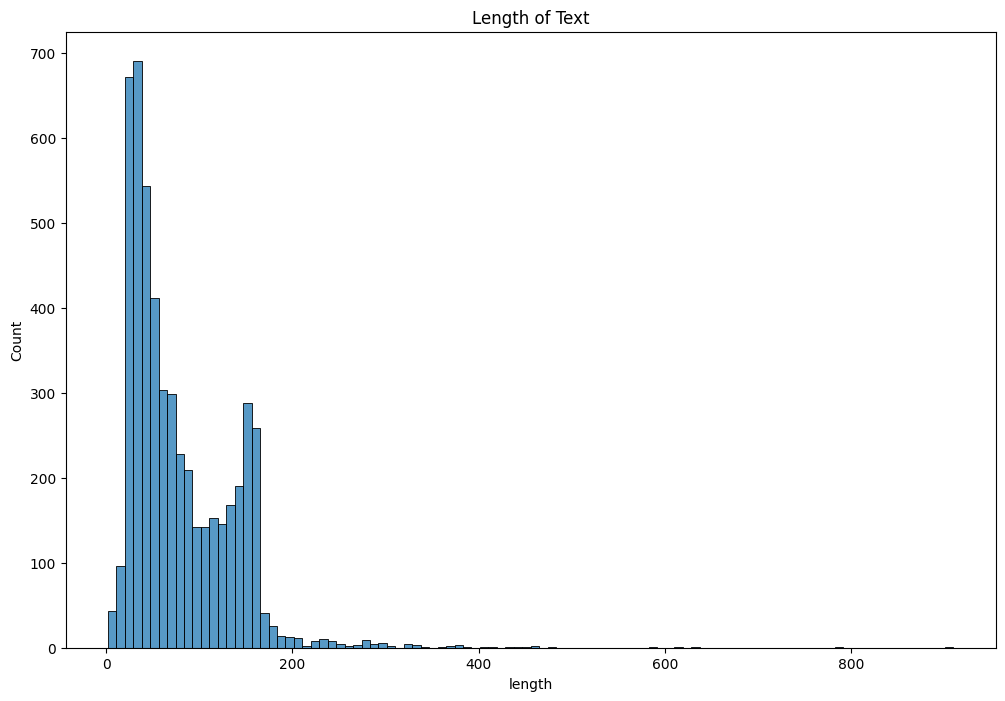

In [206]:
plt.figure(figsize=(12,8))
sns.histplot(x='length', data=mail, bins=100)
plt.title('Length of Text')

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

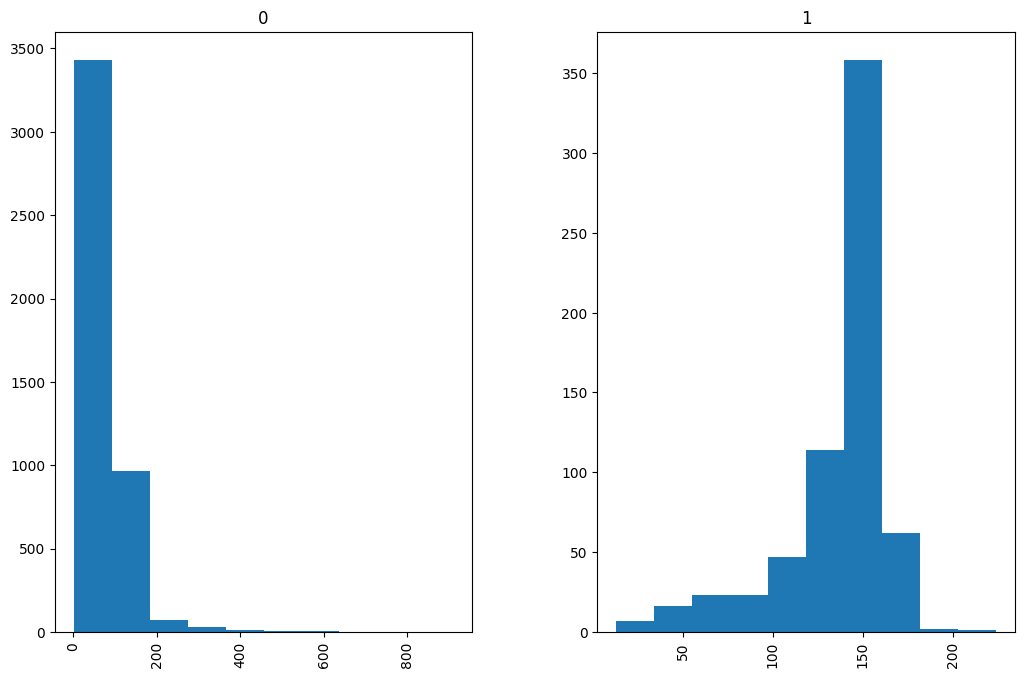

In [207]:
# distribution of spam and ham by length of text
mail.hist(column='length',by='label',figsize=(12,8))

In [208]:
# function to remove punctuation and stopwords
def text_process(text):
    non_punc = [char for char in text if char not in string.punctuation]
    non_punc=''.join(non_punc)
    return [word for word in non_punc.split() if word not in stopwords.words('english')]

In [209]:
# define X(features), y(target)
X = mail['text']
y = mail['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [210]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [211]:
#Creating new Feature

#1. 'num_of_Character'
mail['num_of_character'] =mail['text'].apply(len)

#2. 'num of words'
mail['num_word'] = mail['text'].apply(lambda x:len(nltk.word_tokenize(x)))

#3. 'num_sentences'
mail['num_sentence'] = mail['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [212]:
mail[['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [213]:
#Analysis where label == 0 (ham)
mail[mail['label'] == 0][['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [214]:
#Analysis where label == 1(spam)
mail[mail['label'] ==1][['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


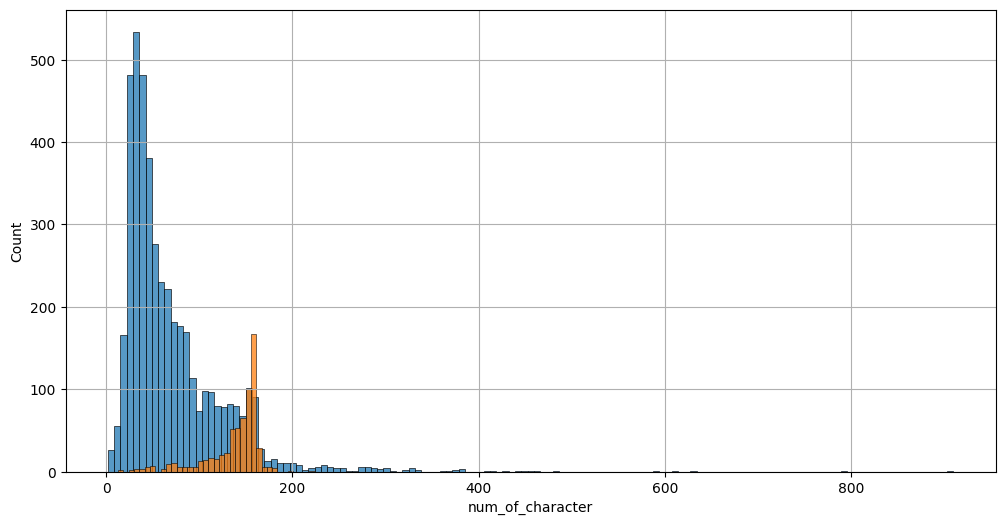

In [215]:
#Now see these conclusions by graphically
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(mail[mail['label'] == 0]['num_of_character'])
sns.histplot(mail[mail['label'] == 1]['num_of_character'])
plt.grid()

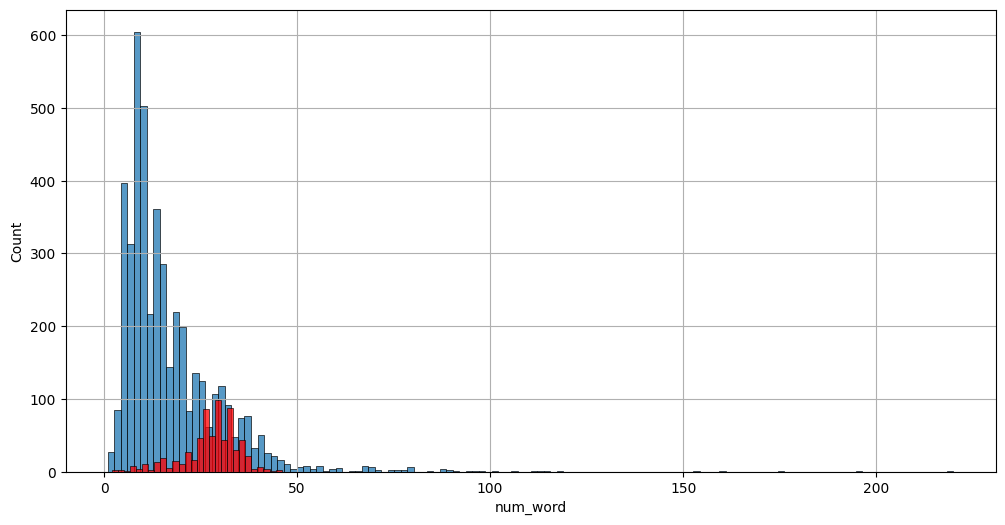

In [216]:
plt.figure(figsize=(12,6))
sns.histplot(mail[mail['label'] == 0]['num_word'])
sns.histplot(mail[mail['label'] == 1]['num_word'],color='red')
plt.grid()

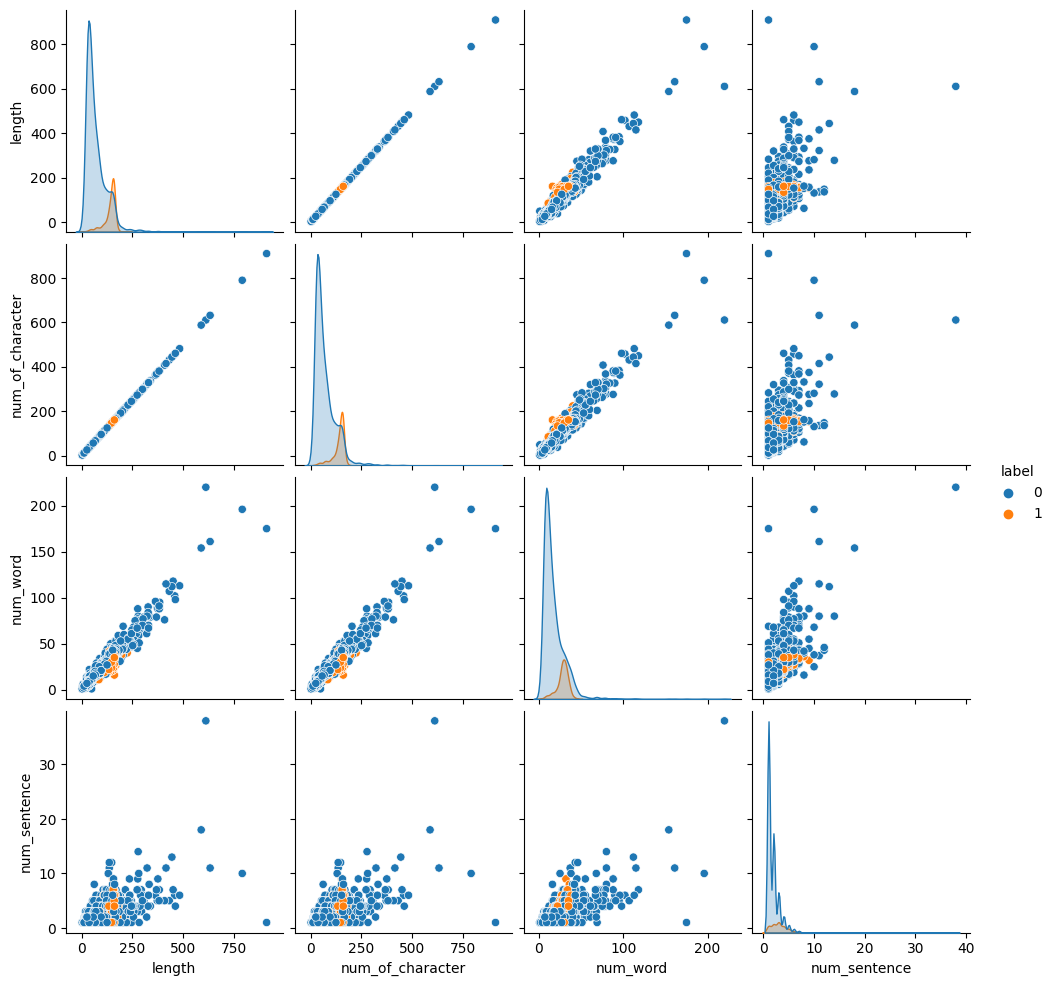

In [217]:
sns.pairplot(mail ,hue='label')
plt.grid()

<Axes: >

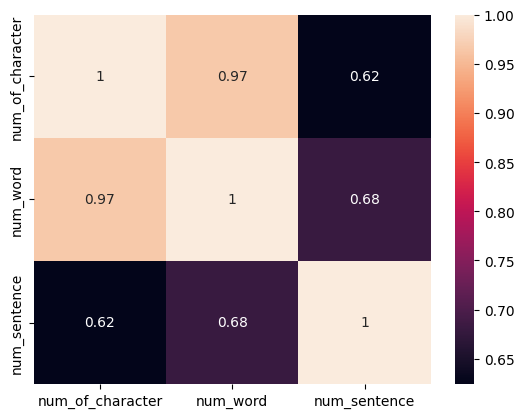

In [218]:
sns.heatmap(mail[['num_of_character','num_word','num_sentence']].corr(),annot=True)

In [219]:
#Define fuction 'Word Frenqeuncy'

def word_freq(data, label, text, title):
    freq_df = data[data["label"] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

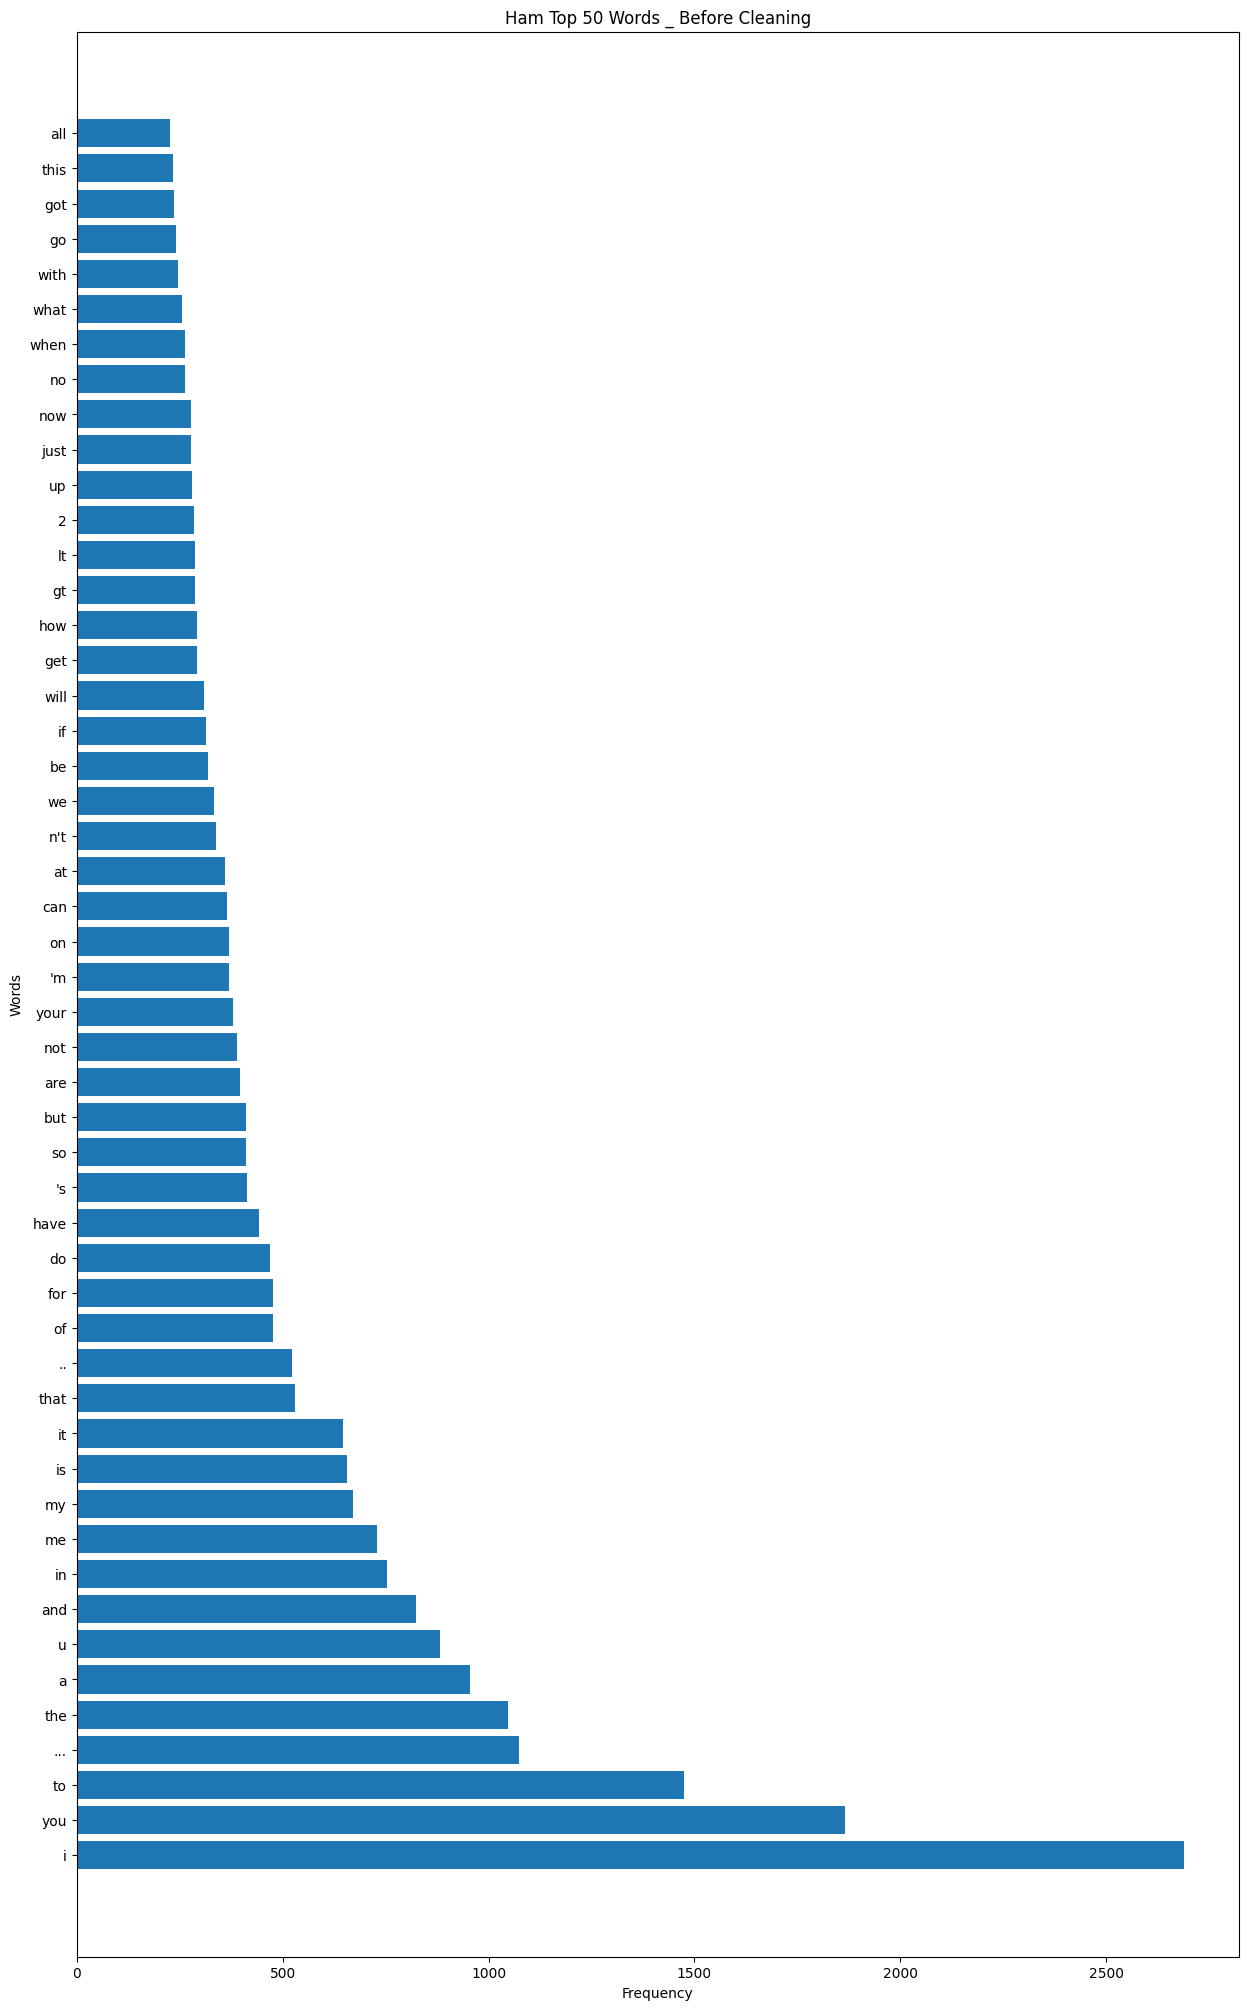

In [220]:
ham_freq_top = word_freq(mail, 0, "text", "Ham Top 50 Words _ Before Cleaning")

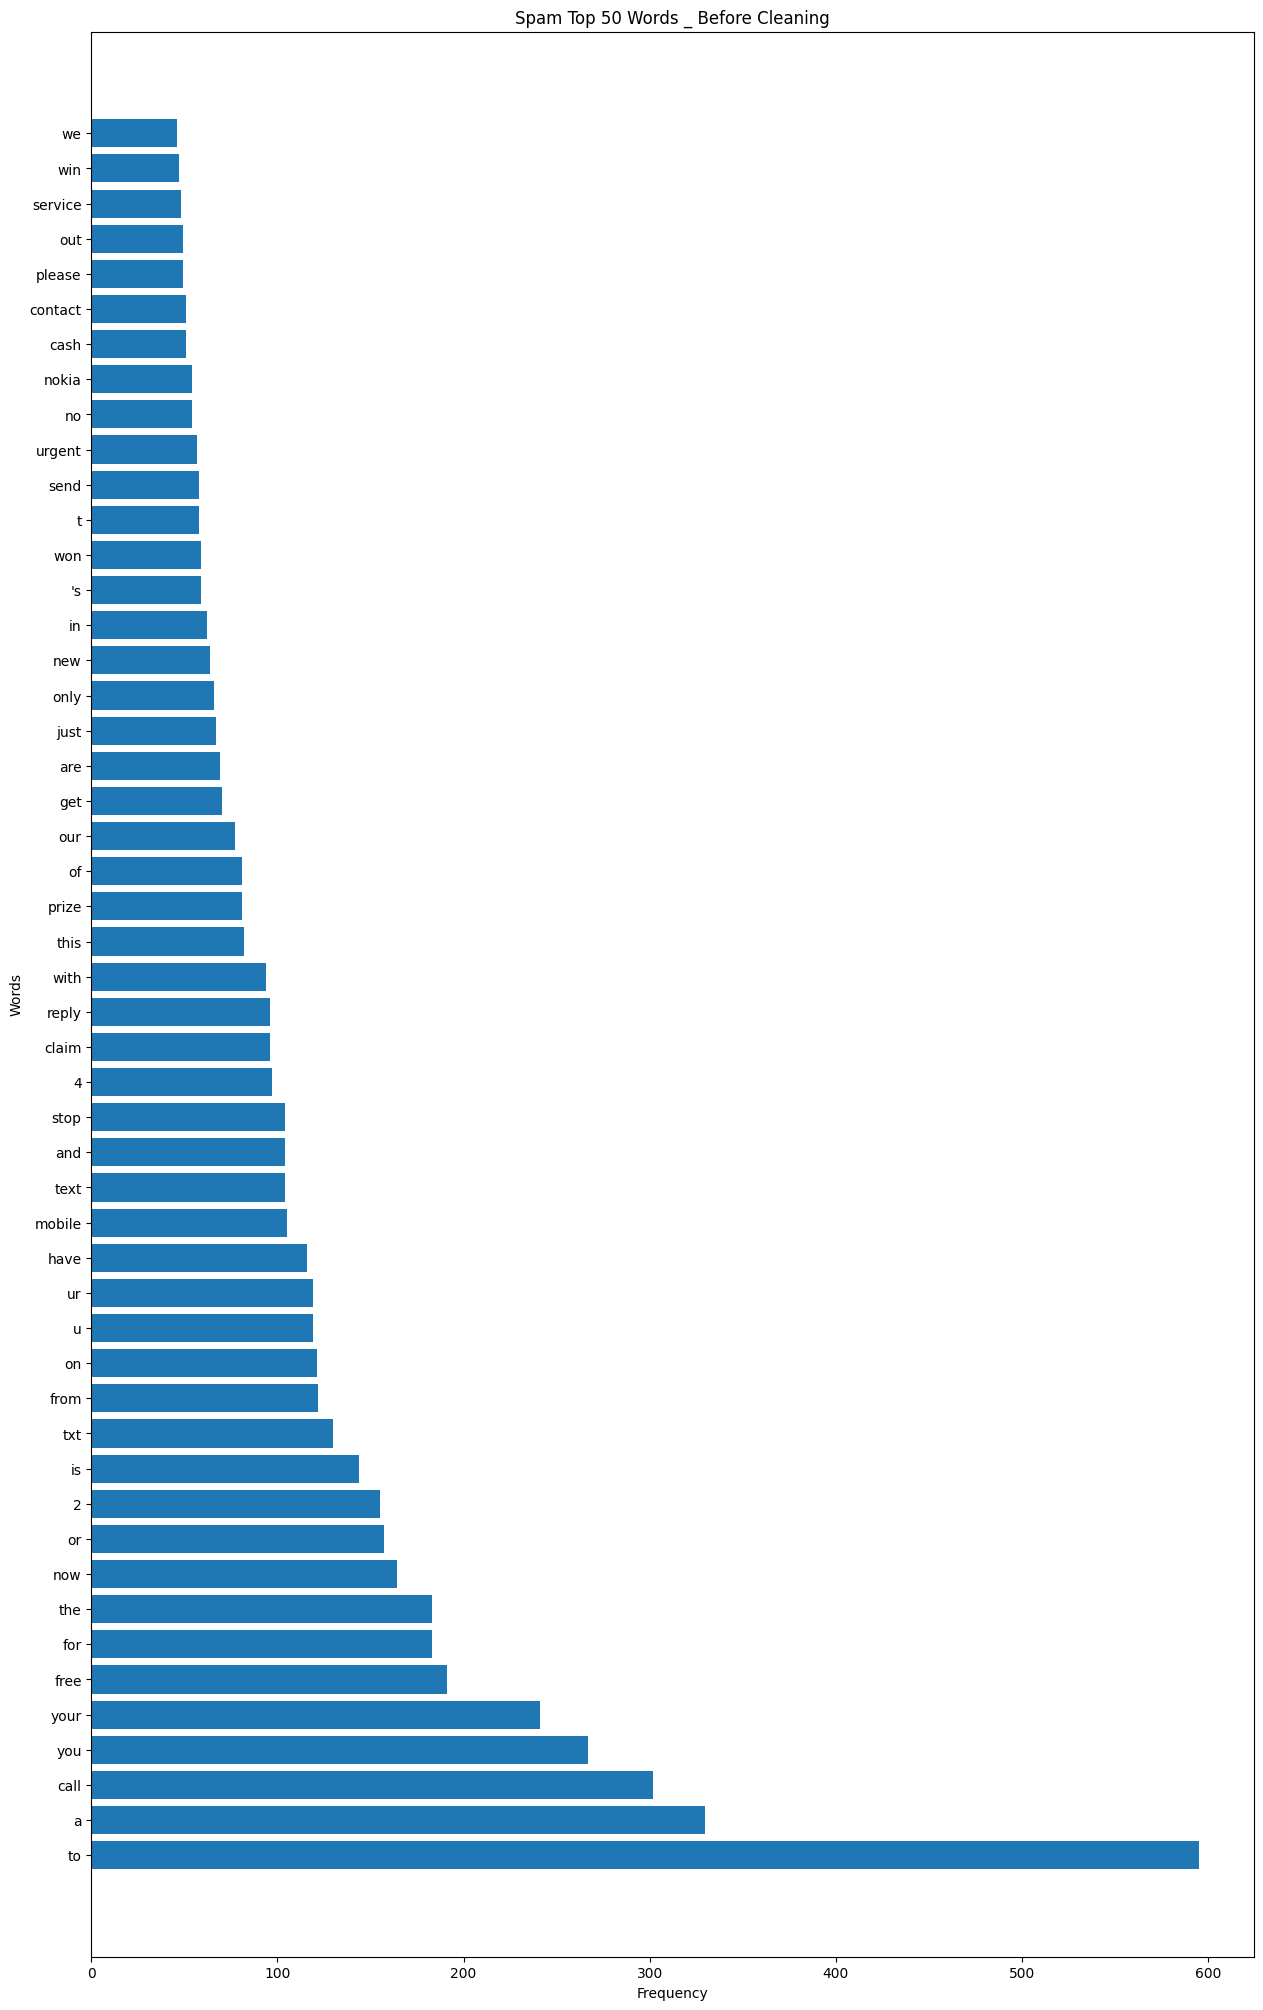

In [221]:
spam_freq_top = word_freq(mail, 1, "text", "Spam Top 50 Words _ Before Cleaning")

In [222]:
def print_wordcloud(freq_top):
    dict_top = dict(freq_top)
    wordcloud = WordCloud(width=700, height=350, background_color="black", min_font_size=5).generate_from_frequencies(dict_top)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

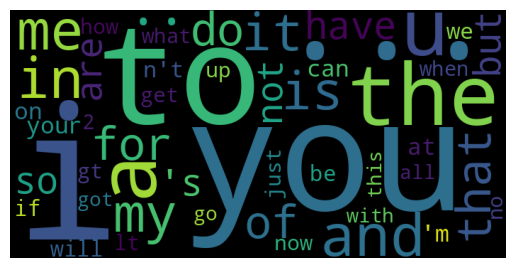

In [223]:
print_wordcloud (ham_freq_top)

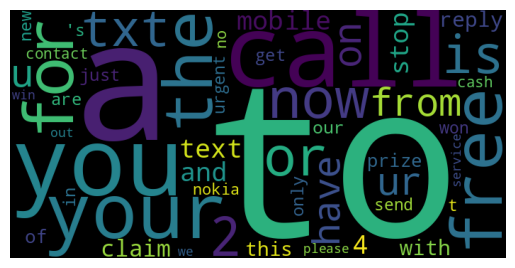

In [224]:
print_wordcloud(spam_freq_top)

In [225]:
#Data Preprocessing
stop_words = set(stopwords.words("english"))

In [226]:
smart_words = '/content/SmartStoplist.txt'

In [227]:
smart_stoplist = []

In [228]:
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [229]:
smart_stoplist

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'c

In [230]:
smart_stoplist.append("_")

In [231]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [232]:
!ls -l ~/nltk_data/

total 40
drwxr-xr-x  3 root root 4096 Dec  4 11:12 chunkers
drwxr-xr-x 74 root root 4096 Dec  4 11:12 corpora
drwxr-xr-x  7 root root 4096 Dec  4 11:12 grammars
drwxr-xr-x  3 root root 4096 Dec  4 11:12 help
drwxr-xr-x  4 root root 4096 Dec  4 11:12 misc
drwxr-xr-x  6 root root 4096 Dec  4 11:12 models
drwxr-xr-x  2 root root 4096 Dec  4 11:12 sentiment
drwxr-xr-x  4 root root 4096 Dec  4 11:12 stemmers
drwxr-xr-x  6 root root 4096 Dec  4 11:12 taggers
drwxr-xr-x  3 root root 4096 Dec  4 10:46 tokenizers


In [233]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

def clean(text):
    text = re.sub(r'Subject: re :.*subject : re : ', '', text, flags=re.IGNORECASE)
    text = re.sub("Subject:", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)

    text = " ".join([word for word in text.split() if word not in smart_stoplist])

    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

cp: cannot stat '/usr/share/nltk_data/corpora/wordnet2022': No such file or directory


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [234]:
mail["clean"] = mail["text"].apply(clean)

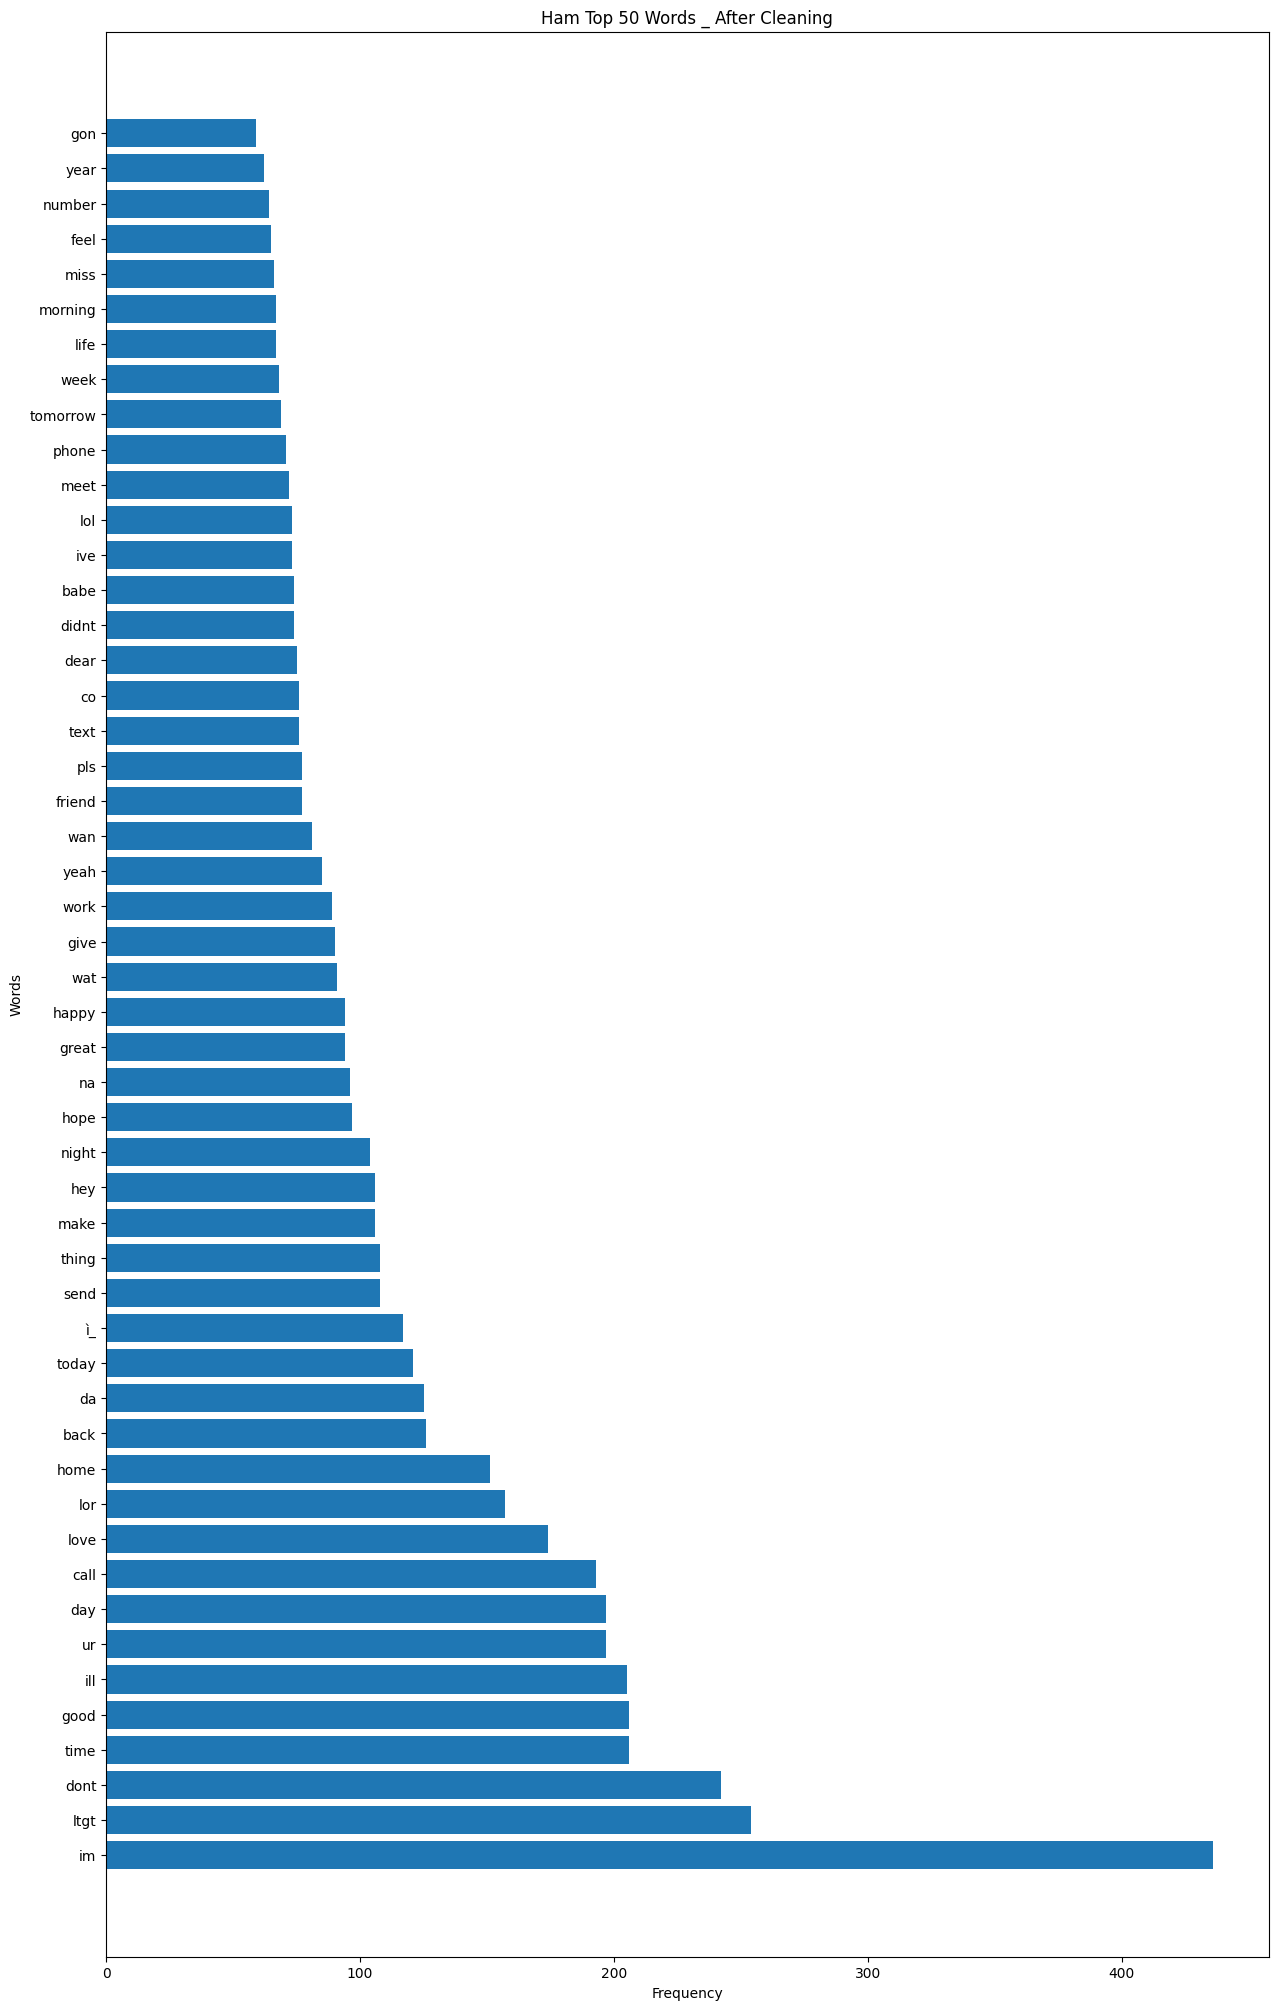

In [235]:
clean_ham_freq_top = word_freq(mail, 0, "clean", "Ham Top 50 Words _ After Cleaning")

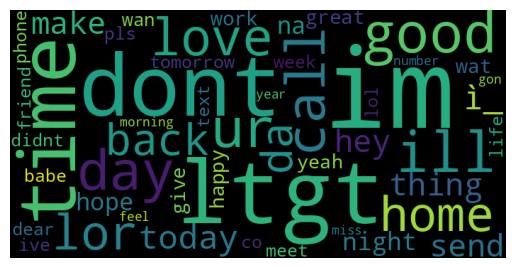

In [236]:
print_wordcloud(clean_ham_freq_top)

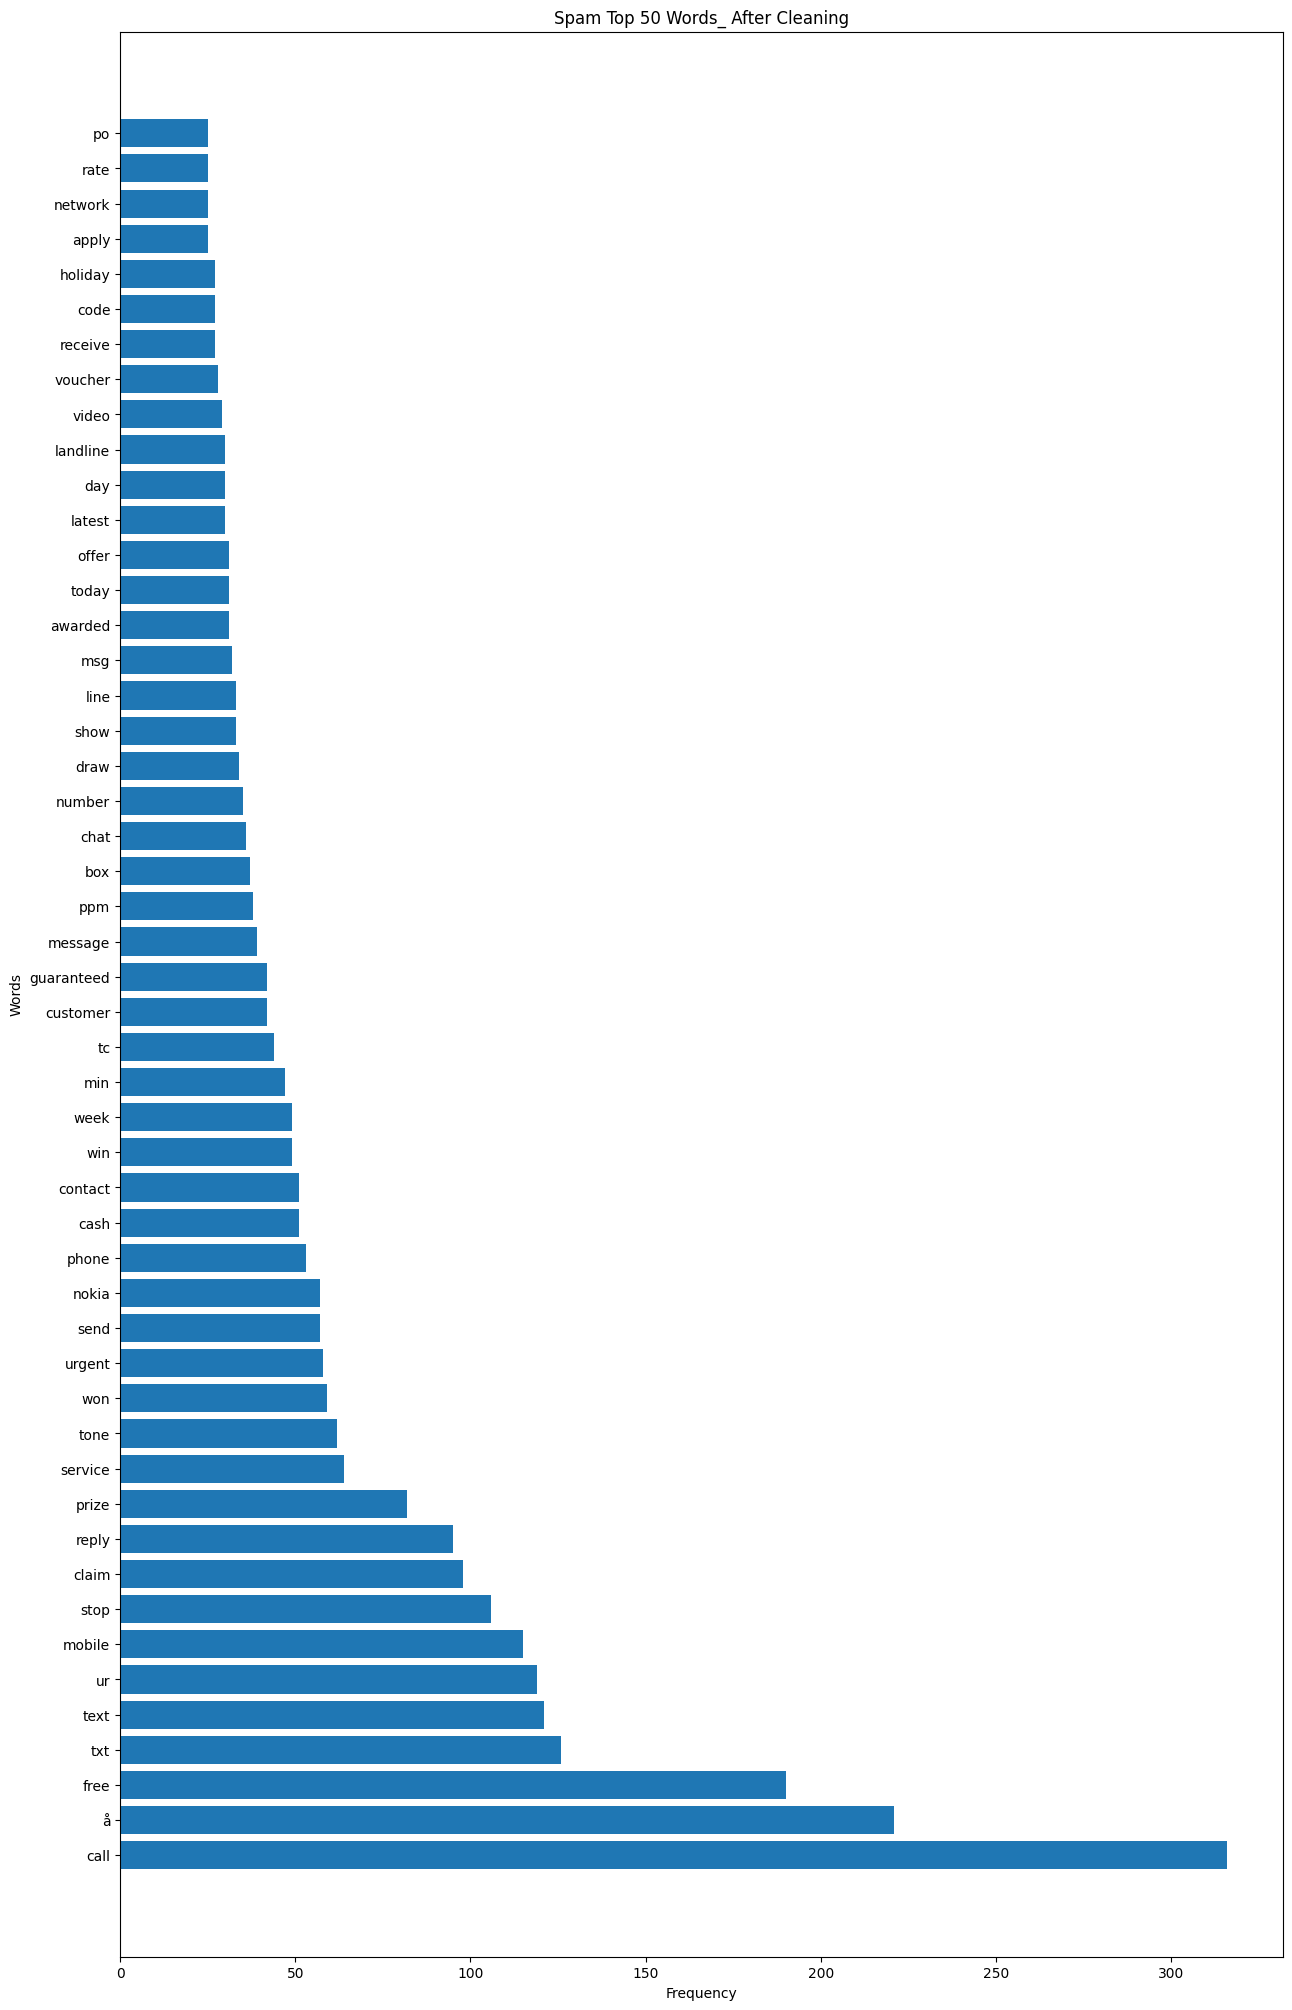

In [237]:
clean_spam_freq_top = word_freq(mail, 1, "clean", "Spam Top 50 Words_ After Cleaning")

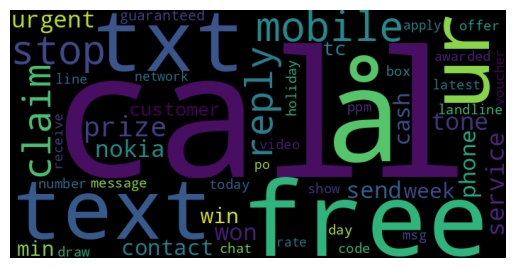

In [238]:
print_wordcloud(clean_spam_freq_top)

In [239]:
#Feature Scaling
X = mail["clean"]
y = mail["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

maxlen = 100

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=400000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [240]:
word_index = tokenizer.word_index
len(word_index)

7643

In [241]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [242]:
input_dim = len(tokenizer.word_index) + 1
input_dim

7644

In [243]:
import tqdm

embeddings_index = {}
mail =  open("/content/df.csv", "r",  encoding="latin-1")
for line in tqdm.tqdm(mail):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray([val for val in values[1:]])
    embeddings_index[word] = coefs

mail.close()
print("Found %s word vectors." % len(embeddings_index))

5575it [00:00, 119255.42it/s]

Found 1855 word vectors.


In [244]:
embedding_matrix = np.zeros((input_dim, 300))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 7643/7643 [00:00<00:00, 1367388.90it/s]


In [245]:
simplernn = Sequential([
    Input(shape = X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    SimpleRNN(100),
    Dense(1, activation='sigmoid')
])

simplernn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

simplernn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 32)           244608    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               13300     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 258009 (1007.85 KB)
Trainable params: 258009 (1007.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [246]:
model1_train_start = time.time()
simplernn_history = simplernn.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model1_train_end = time.time()
model1_train_time = model1_train_end - model1_train_start
print("Model1 Train Time = ", model1_train_time)

Epoch 1/5
59/59 [==============================] - 13s 194ms/step - loss: 0.4059 - accuracy: 0.8613 - val_loss: 0.3198 - val_accuracy: 0.9130
Epoch 2/5
59/59 [==============================] - 10s 163ms/step - loss: 0.3562 - accuracy: 0.8732 - val_loss: 0.2816 - val_accuracy: 0.9130
Epoch 3/5
59/59 [==============================] - 6s 110ms/step - loss: 0.1986 - accuracy: 0.9258 - val_loss: 0.0701 - val_accuracy: 0.9831
Epoch 4/5
59/59 [==============================] - 8s 135ms/step - loss: 0.0538 - accuracy: 0.9847 - val_loss: 0.0580 - val_accuracy: 0.9783
Epoch 5/5
59/59 [==============================] - 6s 103ms/step - loss: 0.0307 - accuracy: 0.9919 - val_loss: 0.0555 - val_accuracy: 0.9783
Model1 Train Time =  43.15884518623352


In [247]:
model1_test_start = time.time()
simplernn_pred_test = simplernn.predict(X_test_tokenizer)
model1_test_end = time.time()
model1_test_time = model1_test_end - model1_test_start
print("Model1 Test Time = ", model1_test_time)

33/33 [==============================] - 0s 9ms/step
Model1 Test Time =  0.4942483901977539


In [248]:
simplernn_pred_train = simplernn.predict(X_train_tokenizer)
simplernn_pred_train = [1 if i > 0.5 else 0 for i in simplernn_pred_train]
simplernn_pred_test = [1 if i > 0.5 else 0 for i in simplernn_pred_test]
simplernn_train_score = accuracy_score(simplernn_pred_train, y_train)
simplernn_test_score = accuracy_score(simplernn_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn_train_score * 100:.2f}%")
print(f"SimpleRNN Test Score = {simplernn_test_score * 100:.2f}%")

130/130 [==============================] - 1s 9ms/step
SimpleRNN Train Score = 99.13%
SimpleRNN Test Score = 97.39%


In [249]:
simplernn_precision_score = precision_score(y_test, simplernn_pred_test)
simplernn_f1_score = f1_score(y_test, simplernn_pred_test)
simplernn_recall_score = recall_score(y_test, simplernn_pred_test)
simplernn_accuracy_score = accuracy_score(y_test, simplernn_pred_test)

print(f"SimpleRNN Precision Score = {simplernn_precision_score * 100:.2f}%")
print(f"SimpleRNN F1 Score = {simplernn_f1_score * 100:.2f}%")
print(f"SimpleRNN Recall Score = {simplernn_recall_score * 100:.2f}%")
print(f"SimpleRNN Accuracy Score = {simplernn_accuracy_score * 100:.2f}%")

SimpleRNN Precision Score = 96.09%
SimpleRNN F1 Score = 90.11%
SimpleRNN Recall Score = 84.83%
SimpleRNN Accuracy Score = 97.39%


In [250]:
print(classification_report(y_test, simplernn_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       889
        spam       0.96      0.85      0.90       145

    accuracy                           0.97      1034
   macro avg       0.97      0.92      0.94      1034
weighted avg       0.97      0.97      0.97      1034



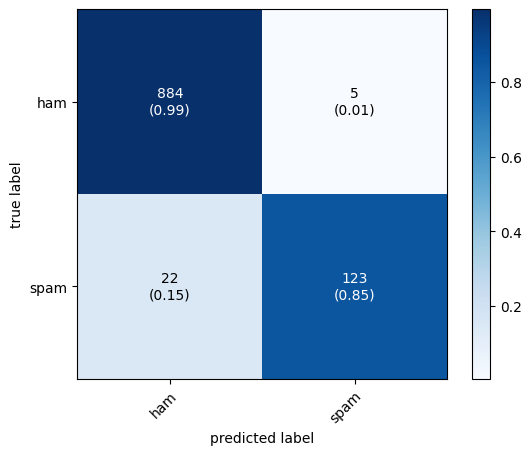

In [251]:
simplernn_cm = confusion_matrix(y_test, simplernn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

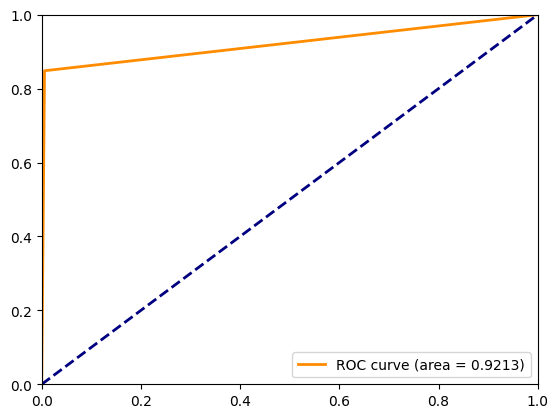

In [252]:
fpr, tpr, _ = roc_curve(y_test, simplernn_pred_test)
simplernn_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC curve (area = {simplernn_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [253]:
#LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import time
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

In [254]:
lstm = Sequential([
    Input(shape = X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 32)           244608    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 297909 (1.14 MB)
Trainable params: 297909 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [255]:
model2_train_start = time.time()
lstm_results = lstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model2_train_end = time.time()
model2_train_time = model2_train_end - model2_train_start
print("Model2 Train Time = ", model2_train_time)

Epoch 1/5
59/59 [==============================] - 8s 91ms/step - loss: 0.3626 - accuracy: 0.8689 - val_loss: 0.2039 - val_accuracy: 0.9541
Epoch 2/5
59/59 [==============================] - 3s 54ms/step - loss: 0.1089 - accuracy: 0.9696 - val_loss: 0.0510 - val_accuracy: 0.9807
Epoch 3/5
59/59 [==============================] - 3s 41ms/step - loss: 0.0442 - accuracy: 0.9876 - val_loss: 0.0514 - val_accuracy: 0.9807
Epoch 4/5
59/59 [==============================] - 3s 48ms/step - loss: 0.0268 - accuracy: 0.9914 - val_loss: 0.0491 - val_accuracy: 0.9855
Epoch 5/5
59/59 [==============================] - 2s 24ms/step - loss: 0.0168 - accuracy: 0.9962 - val_loss: 0.0554 - val_accuracy: 0.9855
Model2 Train Time =  18.64901351928711


In [256]:
model2_test_start = time.time()
lstm_pred_test = lstm.predict(X_test_tokenizer)
model2_test_end = time.time()
model2_test_time = model2_test_end - model2_test_start
print("Model2 Test Time = ", model2_test_time)

33/33 [==============================] - 0s 3ms/step
Model2 Test Time =  0.6512832641601562


In [257]:
lstm_pred_train = lstm.predict(X_train_tokenizer)
lstm_pred_train = [1 if i > 0.5 else 0 for i in lstm_pred_train]
lstm_pred_test = [1 if i > 0.5 else 0 for i in lstm_pred_test]
lstm_train_score = accuracy_score(lstm_pred_train, y_train)
lstm_test_score = accuracy_score(lstm_pred_test, y_test)
print(f"LSTM Train Score = {lstm_train_score * 100:.2f}%")
print(f"LSTM Test Score = {lstm_test_score * 100:.2f}%")

130/130 [==============================] - 0s 3ms/step
LSTM Train Score = 99.54%
LSTM Test Score = 97.87%


In [258]:
lstm_precision_score = precision_score(y_test, lstm_pred_test)
lstm_f1_score = f1_score(y_test, lstm_pred_test)
lstm_recall_score = recall_score(y_test, lstm_pred_test)
lstm_accuracy_score = accuracy_score(y_test, lstm_pred_test)

print(f"LSTM Precision Score = {lstm_precision_score * 100:.2f}%")
print(f"LSTM F1 Score = {lstm_f1_score * 100:.2f}%")
print(f"LSTM Recall Score = {lstm_recall_score * 100:.2f}%")
print(f"LSTM Accuracy Score = {lstm_accuracy_score * 100:.2f}%")

LSTM Precision Score = 95.56%
LSTM F1 Score = 92.14%
LSTM Recall Score = 88.97%
LSTM Accuracy Score = 97.87%


In [259]:
print(classification_report(y_test, lstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.96      0.89      0.92       145

    accuracy                           0.98      1034
   macro avg       0.97      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



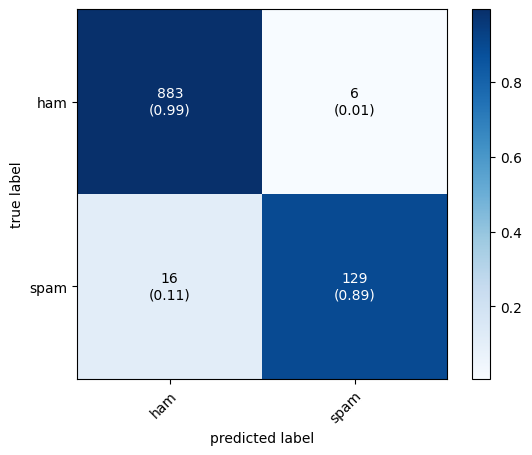

In [260]:
lstm_cm = confusion_matrix(y_test, lstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

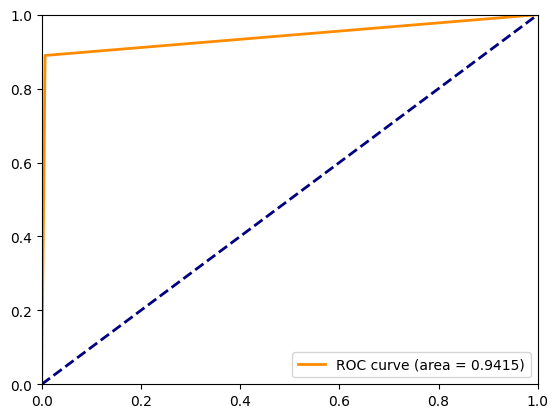

In [261]:
fpr, tpr, _ = roc_curve(y_test, lstm_pred_test)
lstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [277]:
scores_mail = pd.DataFrame(columns=["Model Name", "Train Time", "Test Time", "Train Score", "Test Score",
                                  "Accuracy", "F1", "Precision", "Recall", "ROC-AUC"])

In [278]:
scores_mail.loc[1] = ["SimpleRNN",
                    model1_train_time,
                    model1_test_time,
                    simplernn_train_score,
                    simplernn_test_score,
                    simplernn_accuracy_score,
                    simplernn_f1_score,
                    simplernn_precision_score,
                    simplernn_recall_score,
                    simplernn_roc_auc]

In [279]:
scores_mail.loc[2] = ["LSTM",
                    model2_train_time,
                    model2_test_time,
                    lstm_train_score,
                    lstm_test_score,
                    lstm_accuracy_score,
                    lstm_f1_score,
                    lstm_precision_score,
                    lstm_recall_score,
                    lstm_roc_auc]

In [280]:
scores_mail

,Model Name,Train Time,Test Time,Train Score,Test Score,Accuracy,F1,Precision,Recall,ROC-AUC
1,SimpleRNN,43.158845,0.494248,0.991294,0.973888,0.973888,0.901099,0.960938,0.848276,0.921326
2,LSTM,18.649014,0.651283,0.995405,0.978723,0.978723,0.921429,0.955556,0.889655,0.941453
